<a href="https://colab.research.google.com/github/RizanPSTU/Python-LCC-data/blob/master/MobilenetV2DeeplabRizan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
ls

sample_data/


In [0]:
import sys

In [3]:
print(sys.version)

2.7.15rc1 (default, Nov 12 2018, 14:31:15) 
[GCC 7.3.0]


In [0]:
#!pip install tensorflow-gpu==1.13.1

In [5]:
#!pip install tensorflow==1.13.1
import tensorflow as tf
print(tf.__version__)

1.13.1


In [6]:
%cd
!git clone https://github.com/RizanPSTU/models.git

/root
Cloning into 'models'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 25983 (delta 70), reused 21 (delta 10), pack-reused 25873
Receiving objects: 100% (25983/25983), 508.57 MiB | 41.19 MiB/s, done.
Resolving deltas: 100% (15601/15601), done.
Checking out files: 100% (2907/2907), done.


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [8]:
ls

models/


In [0]:
#%cd models/research/
# From tensorflow/models/research/
#!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

In [10]:
%cd

/root


In [11]:
ls

models/


In [12]:
%cd models/research/deeplab/
!sh ./local_test_mobilenetv2.sh

/root/models/research/deeplab

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

testBuildDeepLabWithDensePredictionCell (__main__.DeeplabModelTest) ... WARNING:tensorflow:From /usr/lib/python2.7/contextlib.py:84: test_session (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.
2019-05-18 11:46:02.704200: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-05-18 11:46:02.704505: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55b4aed80c00 executing computations on platform Host. Devices:
2019-05-18 11:46:02.704537: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
20

In [0]:
model_dir = 'research/deeplab/datasets/pascal_voc_seg/exp/train_on_trainval_set_mobilenetv2/export/'

In [0]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import gridspec

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'leaf'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [15]:
%cd

/root


In [16]:
ls

models/


In [17]:
%cd models/research/deeplab/datasets/pascal_voc_seg/init_models

/root/models/research/deeplab/datasets/pascal_voc_seg/init_models


In [18]:
ls

deeplabv3_mnv2_pascal_train_aug/
deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz


In [19]:
%cd

/root


In [20]:
ls

models/


In [21]:
%cd models

/root/models


In [22]:
ls

AUTHORS     CONTRIBUTING.md    LICENSE    README.md  samples/    WORKSPACE
CODEOWNERS  ISSUE_TEMPLATE.md  official/  research/  tutorials/


In [23]:
import os
import tarfile

_MODEL_NAME = 'frozen_inference_graph.pb'
_TARBALL_NAME = 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'


_dl_dir ='research/deeplab/datasets/pascal_voc_seg/init_models/'


model_path = os.path.join(model_dir, _MODEL_NAME)
download_path = os.path.join(_dl_dir, _TARBALL_NAME)
with tarfile.open(download_path, "w:gz") as tar:
        tar.add(model_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


Saving re500500leaf1235.jpg to re500500leaf1235 (1).jpg
saved file re500500leaf1235.jpg


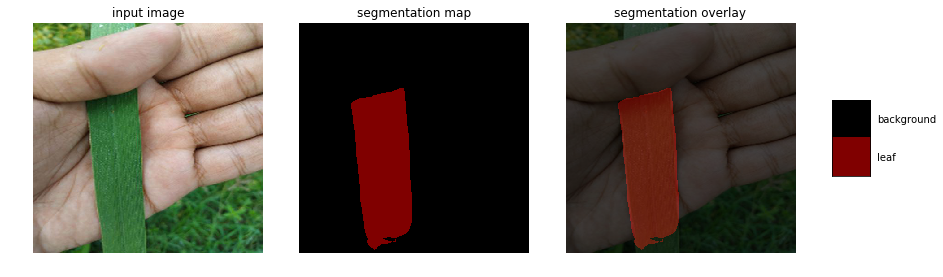

In [28]:
from google.colab import files
from os import path
from PIL import Image

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('img.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    
im = Image.open(name)
resized_im, seg_map = MODEL.run(im)

#plt.imshow(seg_map)

vis_segmentation(resized_im, seg_map)
